# Libraries

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [2]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Preprocess

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tar

In [7]:

# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/4dfa6cec-3835-11ef-9a4d-a220d6984a86.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame=frame[100:100+250, 540:540+250,:] # Crop the image
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


2024-06-28 12:18:53.797 Python[35395:690570] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


# Data Augmentation

In [25]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        #img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data


In [27]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Directories


In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

2024-07-04 17:27:57.965441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-04 17:27:57.965512: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-04 17:27:57.965527: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-04 17:27:57.966139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-04 17:27:57.966170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
dir_test=anchor.as_numpy_iterator()


In [7]:
dir_test.next()

b'data/anchor/c696460a-3838-11ef-9a4d-a220d6984a86.jpg'

In [8]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [9]:
img = preprocess('data/anchor/2a8abc62-34b6-11ef-a71d-a220d6984a86.jpg')

In [10]:
img.numpy().min(), img.numpy().max()

(0.028921569, 1.0)

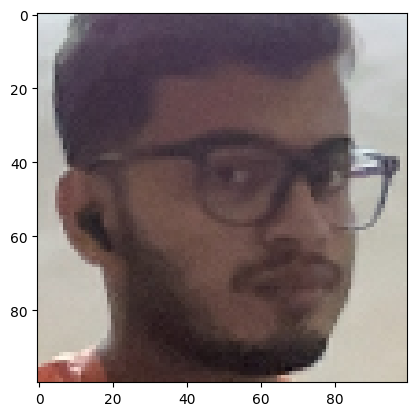

In [11]:
plt.imshow(img)

In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()

In [14]:
exampple = samples.next()


In [15]:
exampple

(b'data/anchor/d05a675c-3838-11ef-9a4d-a220d6984a86.jpg',
 b'data/positive/eee5ad94-3838-11ef-9a4d-a220d6984a86.jpg',
 1.0)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
res = preprocess_twin(*exampple)

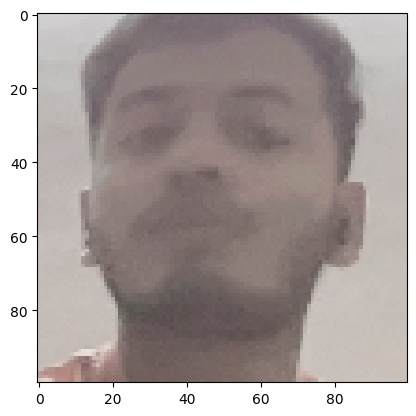

In [18]:
plt.imshow(res[0])

In [19]:
res[2]

1.0

In [20]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [23]:
x=train_data.as_numpy_iterator().next()
x

(array([[[[0.81764704, 0.8098039 , 0.8215686 ],
          [0.82058823, 0.8127451 , 0.8245098 ],
          [0.82058823, 0.8127451 , 0.8245098 ],
          ...,
          [0.7970588 , 0.7970588 , 0.80490196],
          [0.79632354, 0.79632354, 0.8041667 ],
          [0.79607844, 0.7921569 , 0.8117647 ]],
 
         [[0.8088235 , 0.8009804 , 0.8127451 ],
          [0.80220586, 0.7943627 , 0.8061274 ],
          [0.7985294 , 0.79068625, 0.80245095],
          ...,
          [0.79313725, 0.7911765 , 0.8       ],
          [0.79607844, 0.7941176 , 0.8029412 ],
          [0.79607844, 0.7941176 , 0.8029412 ]],
 
         [[0.80588233, 0.7892157 , 0.8039216 ],
          [0.8       , 0.78333336, 0.7980392 ],
          [0.8       , 0.78333336, 0.7980392 ],
          ...,
          [0.79534316, 0.7875    , 0.7992647 ],
          [0.79607844, 0.7882353 , 0.8       ],
          [0.79607844, 0.7882353 , 0.8       ]],
 
         ...,
 
         [[0.8718137 , 0.81666666, 0.79509807],
          [0.77450

# Model


## Embedding Layer

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Distance layer

In [27]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

## Make model

In [28]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [29]:
siamese_model = make_siamese_model()

In [30]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [31]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [32]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [33]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [34]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [35]:
EPOCHS = 50

In [61]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/stepst
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/st

2024-07-02 11:53:12.888565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepste
1/1 ━━━━━━━━

2024-07-02 12:04:08.163173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━

2024-07-02 12:15:37.363974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 12:27:50.554451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━

2024-07-02 12:39:35.578485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━

2024-07-02 12:51:12.205231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 13:02:44.976000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━

2024-07-02 13:14:16.954296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━

2024-07-02 13:26:04.968642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━

2024-07-02 13:37:17.500188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepste
1/1 ━━

2024-07-02 13:48:10.542510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step/ste
1/1 ━━━━━━

2024-07-02 13:59:22.558007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━

2024-07-02 14:10:30.939036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━

2024-07-02 14:21:23.219486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepste
1/1 ━━━━━━━━━━

2024-07-02 14:32:28.940273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 14:43:27.488310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━

2024-07-02 14:55:19.165018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━

2024-07-02 15:08:43.332700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━

2024-07-02 15:21:44.732702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━

2024-07-02 15:42:05.824722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━

2024-07-02 15:53:34.196775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━

2024-07-02 16:05:07.571728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━

2024-07-02 16:16:30.096312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 16:28:28.631875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━

2024-07-02 16:40:36.430667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 16:52:53.725958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━

2024-07-02 17:04:42.215986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━

2024-07-02 17:16:25.420099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepste
1/1 ━━━━━━━━━━━━

2024-07-02 17:27:21.534794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2024-07-02 17:39:07.638830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/

2024-07-02 17:51:01.577699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━

2024-07-02 18:02:55.246663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━

2024-07-02 18:14:08.565778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━

2024-07-02 18:25:52.027420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━

2024-07-02 18:37:50.514525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━

2024-07-02 18:49:42.293629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━

2024-07-02 19:00:52.057856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━

2024-07-02 19:12:23.878973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━

2024-07-02 19:23:51.033379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━

2024-07-02 19:35:56.855506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

2024-07-02 19:48:57.801728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━

2024-07-02 20:01:56.425050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━

2024-07-02 20:13:39.317655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step2s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━

2024-07-02 20:25:36.799279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━

2024-07-02 20:36:48.110990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━

2024-07-02 20:48:52.944350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━

2024-07-02 21:01:21.840257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━

2024-07-02 21:13:47.060533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━

2024-07-02 21:24:52.261588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/stepst
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step3s/ste
1/1 ━━━━━━━━━━━━━

2024-07-02 21:35:45.507150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Evaluation

In [36]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
test_input.shape, test_val.shape, y_true.shape
y_true

array([1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [38]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


2024-07-04 17:28:55.903320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


array([[0.49980748],
       [0.4987595 ],
       [0.5007022 ],
       [0.50049365],
       [0.49725497],
       [0.49753645],
       [0.5001258 ],
       [0.4996907 ],
       [0.49751067],
       [0.49937242],
       [0.49919534],
       [0.49743012],
       [0.49283826],
       [0.4992451 ],
       [0.49892026],
       [0.4996772 ]], dtype=float32)

In [39]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
y_true

array([1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [41]:
test_input.shape

(16, 100, 100, 3)

In [42]:
	
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.25

In [43]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.6666667

In [44]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

2024-07-04 17:29:21.128395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


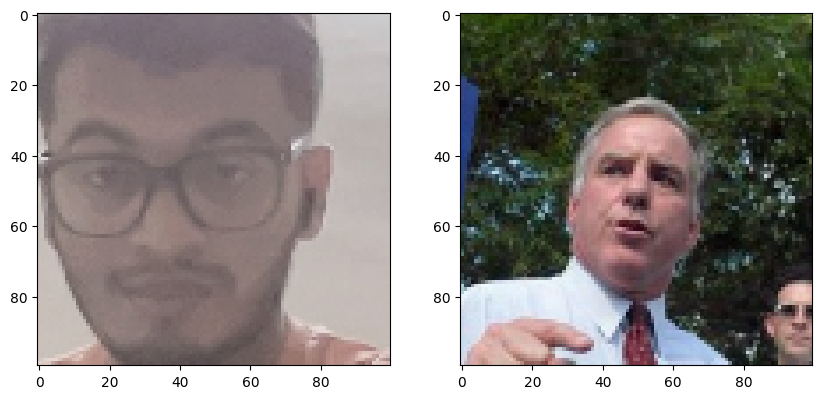

In [162]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

# Renders cleanly
plt.show()

In [71]:
# save model
siamese_model.save('siamese_modelv2.h5')



In [45]:
# Reload model 
model = tf.keras.models.load_model('siamese_modelv2.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [46]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


array([[3.4050782e-14],
       [2.8466998e-10],
       [1.0000000e+00],
       [9.9999964e-01],
       [4.0972854e-14],
       [1.4245536e-16],
       [9.9897659e-01],
       [2.9844824e-10]], dtype=float32)

In [47]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    try:
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
    except tf.errors.InvalidArgumentError:
        print(f"Invalid image file format: {image}")
    continue

In [49]:
os.listdir(os.path.join('application_data', 'verification_images'))

['7d626cb4-34b6-11ef-a71d-a220d6984a86.jpg',
 '7f6debb4-34b6-11ef-a71d-a220d6984a86.jpg',
 '7fed3cb6-34b6-11ef-a71d-a220d6984a86.jpg',
 '0b2aac00-34b7-11ef-a71d-a220d6984a86.jpg',
 '7e2de2e0-34b6-11ef-a71d-a220d6984a86.jpg',
 '08c88a04-34b7-11ef-a71d-a220d6984a86.jpg',
 '7c96c28a-34b6-11ef-a71d-a220d6984a86.jpg',
 '7dfae76e-34b6-11ef-a71d-a220d6984a86.jpg',
 '0a91aab4-34b7-11ef-a71d-a220d6984a86.jpg',
 '0b5d7798-34b7-11ef-a71d-a220d6984a86.jpg',
 '0bc34e92-34b7-11ef-a71d-a220d6984a86.jpg',
 '9ac1f996-34b6-11ef-a71d-a220d6984a86.jpg',
 '7c180620-34b6-11ef-a71d-a220d6984a86.jpg',
 '7dc82a5e-34b6-11ef-a71d-a220d6984a86.jpg',
 '7d162dae-34b6-11ef-a71d-a220d6984a86.jpg',
 '0b9058fc-34b7-11ef-a71d-a220d6984a86.jpg',
 '07fd267a-34b7-11ef-a71d-a220d6984a86.jpg',
 '0bf5ee2e-34b7-11ef-a71d-a220d6984a86.jpg',
 '0ac4e852-34b7-11ef-a71d-a220d6984a86.jpg',
 '7ce38962-34b6-11ef-a71d-a220d6984a86.jpg',
 '7f3b4880-34b6-11ef-a71d-a220d6984a86.jpg',
 '7ef991ba-34b6-11ef-a71d-a220d6984a86.jpg',
 '7d2f55a4

# Real time test

In [50]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    #Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    #Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified



In [51]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame=frame[100:100+250, 540:540+250,:] # Crop the image
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2024-07-04 17:29:41.922 Python[23513:244924] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

In [52]:
a=np.sum(np.squeeze(results)>1e-2)
b=np.squeeze(results)
print(a)
print(b)
len(results)

0
[6.3499367e-17 1.7999605e-15 1.1856819e-16 8.5800914e-15 3.8308043e-15
 2.3876265e-16 7.0540102e-11 5.9521921e-16 2.0444521e-15 1.9562412e-14
 3.0068213e-15 8.6825932e-14 2.1238096e-16 5.8704497e-16 1.6876385e-16
 3.9661814e-15 9.3442727e-16 1.0095019e-14 2.4570844e-15 2.6465743e-16
 4.3471481e-16 1.2605112e-16 1.9617018e-16 8.4436869e-15 3.3925601e-14
 2.8441803e-11 3.2149025e-15 1.3586089e-15 1.5511007e-15 8.4777971e-16
 9.9575438e-11 1.2007298e-16 6.4082172e-17 1.8954879e-16 4.8517922e-14]


35

In [180]:
a/len(results)

0.0